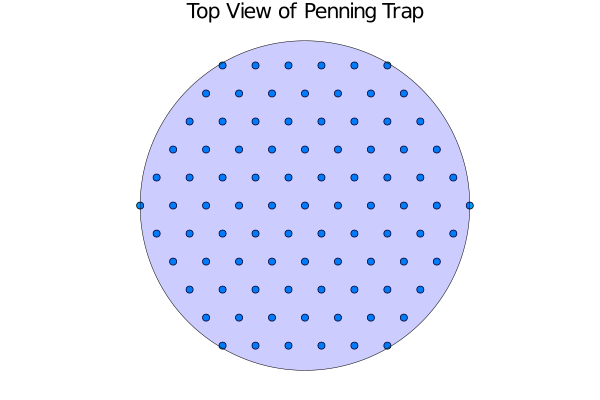

In [8]:
interionic_spacing = .2
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = 1
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)

In [67]:
norm

norm (generic function with 16 methods)

In [72]:
using SpecialFunctions
using QuantumOptics
using ArgParse
using Cubature
using DelimitedFiles


σ1 = .1
σ2 = .1
amp = .001

function fidelity(ρ, σ)
    print(norm(ρ))
    ρ = ρ/norm(ρ)
    σ = σ/norm(σ)
    f = abs(conj(transpose(ρ))*σ)^2
    print(f)
    f
end

function gaussian(σ1, σ2)
    function func(ρ, ϕ)
        x = ρ*cos(ϕ)
        y = ρ*sin(ϕ)
        amp*exp(-x^2/σ1^2 + -y^2/σ2^2)
    end
end

function H_odf(ρ, ϕ, t, zernike_recon, U, ψ, order, ω)
    U * cos(-order*ω*t + ψ + gaussian(σ1, σ2)(ρ, ϕ-ω*t))
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        infid = 1 - real(fidelity(ψ1, ψ2))
        return infid, ψ1, ψ2
    end
end

function sequential_exact_evolution_evaluator_factory(ψ0, T, maxm, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, maxm, step=1)
    function evaluator(ρ, ϕ)
        ψ = ψ0
        for order in orders
            H(t, _) = H_odf(ρ, ϕ, t, 0, U, θ, order, ω)*sigmaz(b)
            _, ψ = timeevolution.schroedinger_dynamic(T, ψ, H)
            ψ = last(ψ)
        end
        ψ
    end
end

function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = gaussian(σ1, σ2)(ρ, ϕ) * sigmaz(b)
    evolution_time = π/(2*amp)
    step_size = evolution_time/1
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.schroedinger_dynamic(T, ψ0, H)
    last(ψ)
end

Γ = 1/62
ω = 2*π*180E3
θ = -π/2;
max_order = 2
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
U = 2 * π * 10E3
evolution_time = π/(2*U*amp)
step_size = evolution_time
T = [0.0:step_size:evolution_time;];
sequential_exact_evolution = sequential_exact_evolution_evaluator_factory(ψ0, T, max_order, U, θ, ω, b)
infids = []
xx = x[1]
yy = y[1]
ρ = sqrt(xx^2 + yy^2)
ϕ = atan(yy, xx)
infid, ψ1, ψ2 = infidelity_across_disk(sequential_exact_evolution, gaussian_spin_profile)(ρ, ϕ)

1.00146552815455060.9999999894448799

(1.055512011127746e-8, Complex{Float64}[7.27171377303261e-5 - 0.7081430623490951im, 7.27171377303261e-5 + 0.7081430623490951im], Complex{Float64}[-3.609188514072585e-8 - 0.7071066852364872im, -3.609188514072585e-8 + 0.7071066852364872im])

In [58]:
# using QuantumOptics
# # Define required parameters
# g =1.0
# Δ = -0.1
# α =4.0
# # Define bases for cavity (Fock) and atom (Spin-1/2)
# bc = FockBasis(40)
# ba = SpinBasis(1//2)
# # Construct operators
# a = destroy(bc) ⊗ one(ba)
# σ⁻ = one(bc) ⊗ sigmam(ba)
# # Construct Hamiltonian
# H = Δ*dagger(a)*a + g*(dagger(a)*σ⁻ + a*dagger(σ⁻))
# # Define initial state
# ψ₀ = coherentstate(bc, α) ⊗ spindown(ba)
# # Define list of time steps
# T = [0:0.01:35;]
# # Evolve in time according to Schrödinger’s equation
# tout, ψₜ = timeevolution.schroedinger(T, ψ₀, H)
# # Calculate atomic excitation
# excitation = expect(dagger(σ⁻)*σ⁻, ψₜ)

In [32]:
sqrt(sqrt(ψ1^2)^2)

2×2 Array{Complex{Float64},2}:
  0.531801+0.0im         -0.499998-0.00133763im
 -0.499998+0.00133763im   0.531801+0.0im

In [36]:
using LinearAlgebra
eigvals(ψ1)

2-element Array{Float64,1}:
 -0.03180142884980586
  1.0318014288498056

In [29]:
[2 2; 2 2]^2

2×2 Array{Int64,2}:
 8  8
 8  8